# Privacy vs. Accuracy

One of the motivating ideas behind differential privacy is that answering too many queries too accurately leaks information about individual records in the data being analyzed. That is, there is a fundamental trade-off between getting accurate statistics and maintaining privacy.

In this notebook, we will look at an example of how the accuracy of the query `mean(age)` changes as a function of the desired privacy level. 

In [2]:
# load libraries
import os
import whitenoise
import whitenoise.components as op

import pandas as pd
import numpy as np
import math

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm
plt.rcParams['figure.figsize'] = [10, 5]

# establish data information
data_path = os.path.join('..', 'data', 'PUMS_california_demographics_1000', 'data.csv')
var_names = ["age", "sex", "educ", "race", "income", "married"]

# load data non-privately
non_priv_data = pd.read_csv(data_path)

In [3]:
''' metadata setup '''
# set sample size
n = 1_000

# set age range
age_range = (0., 100.)

A good point of comparison will be to see what happens when we want `mean(age)` with no noise added. Clamping the data to a range is a necessary pre-processing step for running a differentially private mean, so we will be running our non-private mean on the preprocessed data as well. This will let us better understand the variance increase due to noise addition, rather than the potential bias introduced by clamping the data.  

In [4]:
# pre-process data
clamped_age = np.clip(non_priv_data['age'], age_range[0], age_range[1])
print(np.mean(clamped_age))

44.797


So the true mean of our pre-processed data is 44.797. Let's see what happens when we start releasing private statistics by adding noise.

In [9]:
# set number of simulations
n_sims = 500

# get list of different privacy levels to test
# epsilons = [i/1000 for i in range(1, 1001, 50)]
epsilons = [2**-i for i in range(0, 11) ]
n_epsilons = len(epsilons)

# create n_sims x n_epsilons list of lists to store releases
age_means = [0 for index in range(n_sims * n_epsilons)]

for i in range(len(epsilons)):
#     print('running epsilon = {0}\n\n'.format(epsilons[i]))
    with whitenoise.Analysis() as analysis:
        # load data
        data = whitenoise.Dataset(path = data_path, column_names = var_names)

        # perform simulations
        for j in range(n_sims):
            # get mean of age
            age_means[n_sims*i + j] = op.dp_mean(data = op.cast(data['age'], type = "FLOAT"),
                                  privacy_usage = {'epsilon': epsilons[i]},
                                  data_min = age_range[0],
                                  data_max = age_range[1],
                                  data_n = n
                                 )
        analysis.release()

In [23]:
''' create data set for plotting '''
# convert released values to data frame
# release_df = pd.DataFrame({'value': [mean.value for mean in age_means],
#                            'epsilon': [epsilon for epsilon in epsilons for i in range(n_sims)]})

release_df = pd.DataFrame({'value': [mean.value for mean in age_means],
                           'epsilon': ['2^{0}'.format(-j) for j in range(n_epsilons) for i in range(n_sims)]})

# add other variables
release_df['sq_err'] = (release_df['value'] - np.mean(clamped_age))**2
release_df['log2_sq_err'] = [math.log2(elem) for elem in release_df['sq_err']]

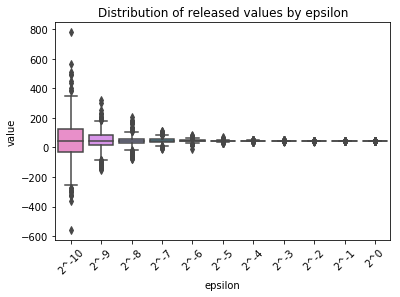

In [24]:
# boxplot of releases by epsilon
boxplot_release = sns.boxplot(x = 'epsilon', y = 'value', data = release_df)
boxplot_release.set_title('Distribution of released values by epsilon')
boxplot_release.invert_xaxis()
boxplot_release.set_xticklabels(boxplot_release.get_xticklabels(), rotation = 45)
plt.show()

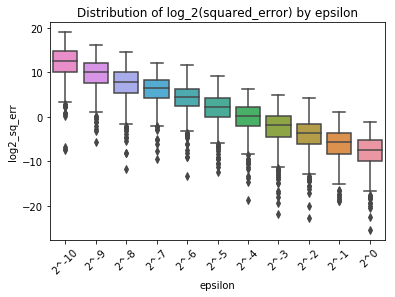

In [25]:
# boxplot of squared error by epsilon
boxplot_sq_err = sns.boxplot(x = 'epsilon', y = 'log2_sq_err', data = release_df)
boxplot_sq_err.set_title('Distribution of log_2(squared_error) by epsilon')
boxplot_sq_err.invert_xaxis()
boxplot_sq_err.set_xticklabels(boxplot_sq_err.get_xticklabels(), rotation=45)
plt.show()

For the analysis above, we used the Laplace Mechanism to release the mean, so the noise we are adding to the statistic is drawn from a Laplace with variance $O(1 / \epsilon^2)$. Thus, the squared error is also of the form $O(1 / \epsilon^2)$ (which corresponds to the linear relationship in the log-log plot above).